### Import the libraries and data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stat
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

lower_bound = 2011
team_colours = {"Ireland": "limegreen", 'New Zealand': "black", 'South Africa': "darkgreen", \
                "Argentina": "royalblue", 'France': 'blue', 'Italy': 'skyblue', \
                "England": "grey", "Scotland": "purple", 'Wales': 'red', 'Australia': 'orange'}
team_list = list(team_colours.keys())
team_list.sort()

team_map = {}
for i in range(len(team_list)):
    team_map[team_list[i]] = i+1

data = pd.read_csv('results.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

/var/folders/68/886mn3q57q9f6lcdshz9b8j80000gn/T/ipykernel_7199/2266670666.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,world_cup
0,1871-03-27,Scotland,England,1,0,1871 Scotland v England International,Raeburn Place,Edinburgh,Scotland,False,False
1,1872-02-05,England,Scotland,2,1,1871–72 Home Nations International,The Oval,London,England,False,False
2,1873-03-03,Scotland,England,0,0,1872–73 Home Nations International,West of Scotland F.C.,Glasgow,Scotland,False,False
3,1874-02-23,England,Scotland,1,0,1873–74 Home Nations International,The Oval,London,England,False,False
4,1875-02-15,England,Ireland,2,0,1874–75 Home Nations rugby union matches,The Oval,London,England,False,False


### Pre-process the data to look only at non-neutral, non-world cup games starting from 2016 (arbitrary) onwards. 
- I want to consider the last 5 years and look to predict the 2024 Six Nations results

In [2]:
df = data[(data['neutral'] == False) & (data['world_cup'] == False)  & (data['date'].dt.year >= lower_bound)]\
        .drop(columns=['competition', 'stadium', 'city', 'country', 'neutral', 'world_cup'])
df['score_diff'] = df['home_score']-df['away_score']
df['home_win'] = df.apply(lambda x: 1 if x['home_score'] > x['away_score'] else 0, axis = 1)
df['away_win'] = df.apply(lambda x: 1 if x['home_score'] < x['away_score'] else 0, axis = 1)
df['draw'] = abs(1 - df['home_win'] - df['away_win'])
df['date'] = pd.to_datetime(df['date'])
df = df.reset_index(drop=True)
df

,date,home_team,away_team,home_score,away_score,score_diff,home_win,away_win,draw
0,2011-02-04,Wales,England,19,26,-7,0,1,0
1,2011-02-05,France,Scotland,34,21,13,1,0,0
2,2011-02-05,Italy,Ireland,11,13,-2,0,1,0
3,2011-02-12,England,Italy,59,13,46,1,0,0
4,2011-02-12,Scotland,Wales,6,24,-18,0,1,0
...,...,...,...,...,...,...,...,...,...
561,2023-08-12,England,Wales,19,17,2,1,0,0
562,2023-08-12,France,Scotland,30,27,3,1,0,0
563,2023-08-19,Wales,South Africa,16,52,-36,0,1,0
564,2023-08-19,Ireland,England,29,10,19,1,0,0


### The plot of how the score_diff changes over time and for each team
- We see that other than the initial portion, the cumulative score difference tends to remain highly positive indicating that there is some benefit to being the home team
- For the northern teams, Italy is the only one on a consisten decline, and for southern teams it is Argentina

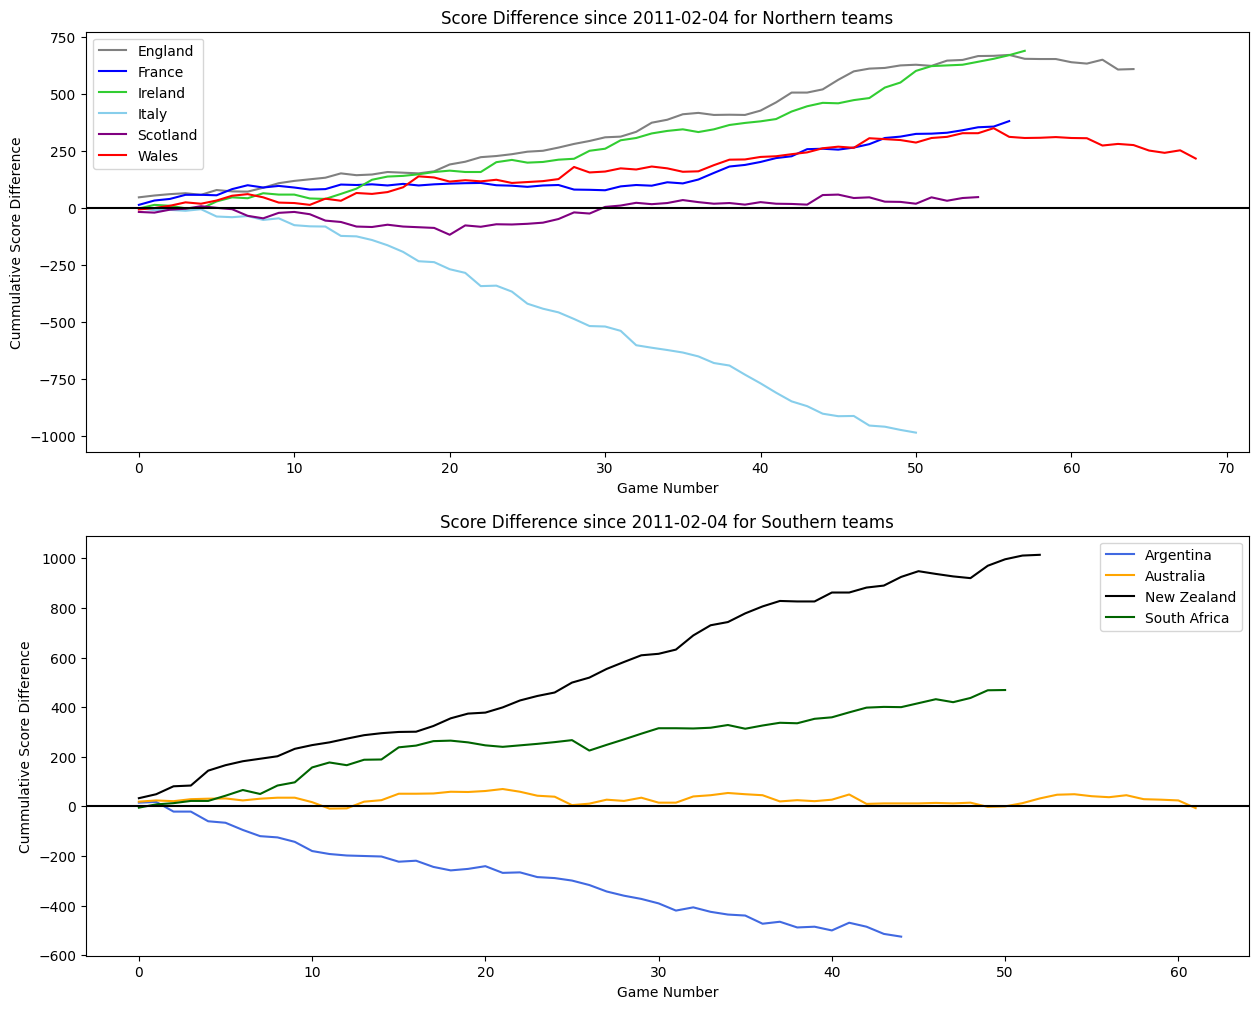

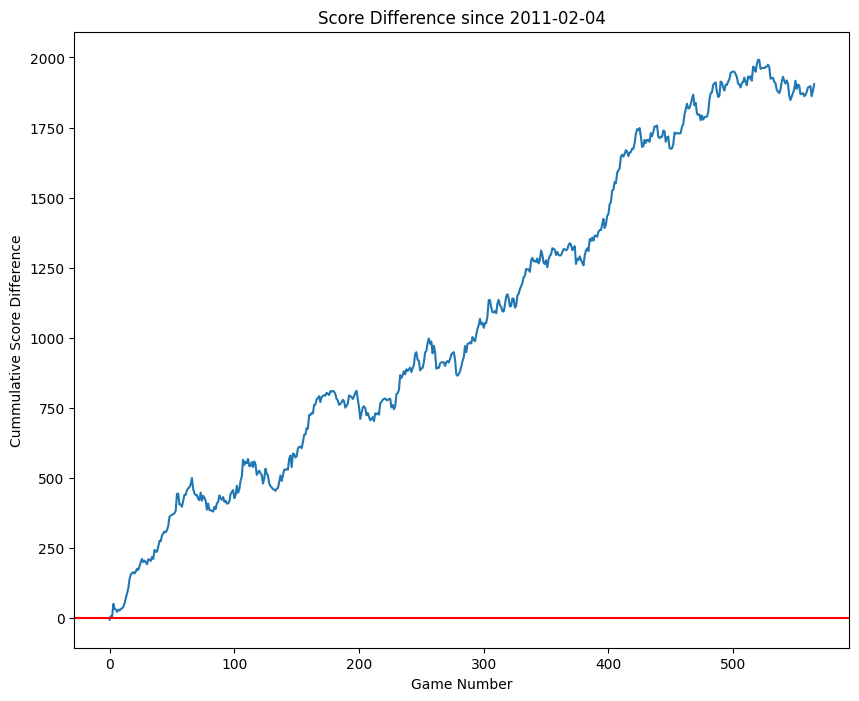

In [3]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 12))
nh = ['Ireland', 'England', 'Scotland', 'Italy', 'France', 'Wales']
nh.sort()

for home_team, data in df.groupby('home_team'):
    subset = data.reset_index(drop = True)
    if home_team in nh:
        axs[0].plot(subset.index, np.cumsum(subset['score_diff']), label=str(home_team), color = team_colours[home_team])
    else:
        axs[1].plot(subset.index, np.cumsum(subset['score_diff']), label=str(home_team), color = team_colours[home_team])

axs[0].set_xlabel('Game Number')
axs[0].set_ylabel('Cummulative Score Difference')
axs[0].set_title('Score Difference since ' + df['date'].dt.strftime("%Y-%m-%d")[0] + " for Northern teams")
axs[0].legend()
axs[0].axhline(y = 0, color = 'black', linestyle = '-')

axs[1].set_xlabel('Game Number')
axs[1].set_ylabel('Cummulative Score Difference')
axs[1].set_title('Score Difference since ' + df['date'].dt.strftime("%Y-%m-%d")[0] + " for Southern teams")
axs[1].legend()
axs[1].axhline(y = 0, color = 'black', linestyle = '-')

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 8))
plt.plot(np.cumsum(df['score_diff']))
plt.xlabel('Game Number')
plt.ylabel('Cummulative Score Difference')
plt.title('Score Difference since ' + df['date'].dt.strftime("%Y-%m-%d")[0])
plt.axhline(y = 0, color = 'r', linestyle = '-')

plt.show()

### We begin our modelling process
- My goal is to use a Random Forest model, with the games from lower_bound onwards to predict the score difference for the team in the 2024 Six Nations results
- We create the df here

In [4]:
team = "Ireland"
six_nations_teams = nh
opposition_map = {}

for key, value in team_map.items():
    if key != team:
        opposition_map[key] = value

## Form the df for the team we are focusing on 
team_df = df[(df['home_team'] == team) | (df['away_team'] == team)].reset_index(drop = True)
team_df["home"] = team_df.apply(lambda x: 1 if x['home_team'] == team else 0, axis = 1)
team_df["away"] = abs(1-team_df["home"])

team_df['score_diff'] = team_df.apply(lambda x: x['home_score'] - x['away_score'] if x['home_team'] == team else -x['home_score'] + x['away_score'], axis = 1)
team_df['home_win'] = team_df.apply(lambda x: 1 if x['home'] == 1 and x['score_diff'] > 0 else 0, axis = 1)
team_df['away_win'] = team_df.apply(lambda x: 1 if x['away'] == 1 and x['score_diff'] > 0 else 0, axis = 1)
team_df['opposition'] = team_df.apply(lambda x: x['away_team'] if x['home_team'] ==  team else x['home_team'], axis = 1)
team_df['opposition'] = team_df.apply(lambda x: opposition_map[x['opposition']], axis = 1)

### We do some correlation analysis to determine the best set of variables, and also whether we need to create lagged variables

home_score
     Lag       CCF
111  111 -0.806056


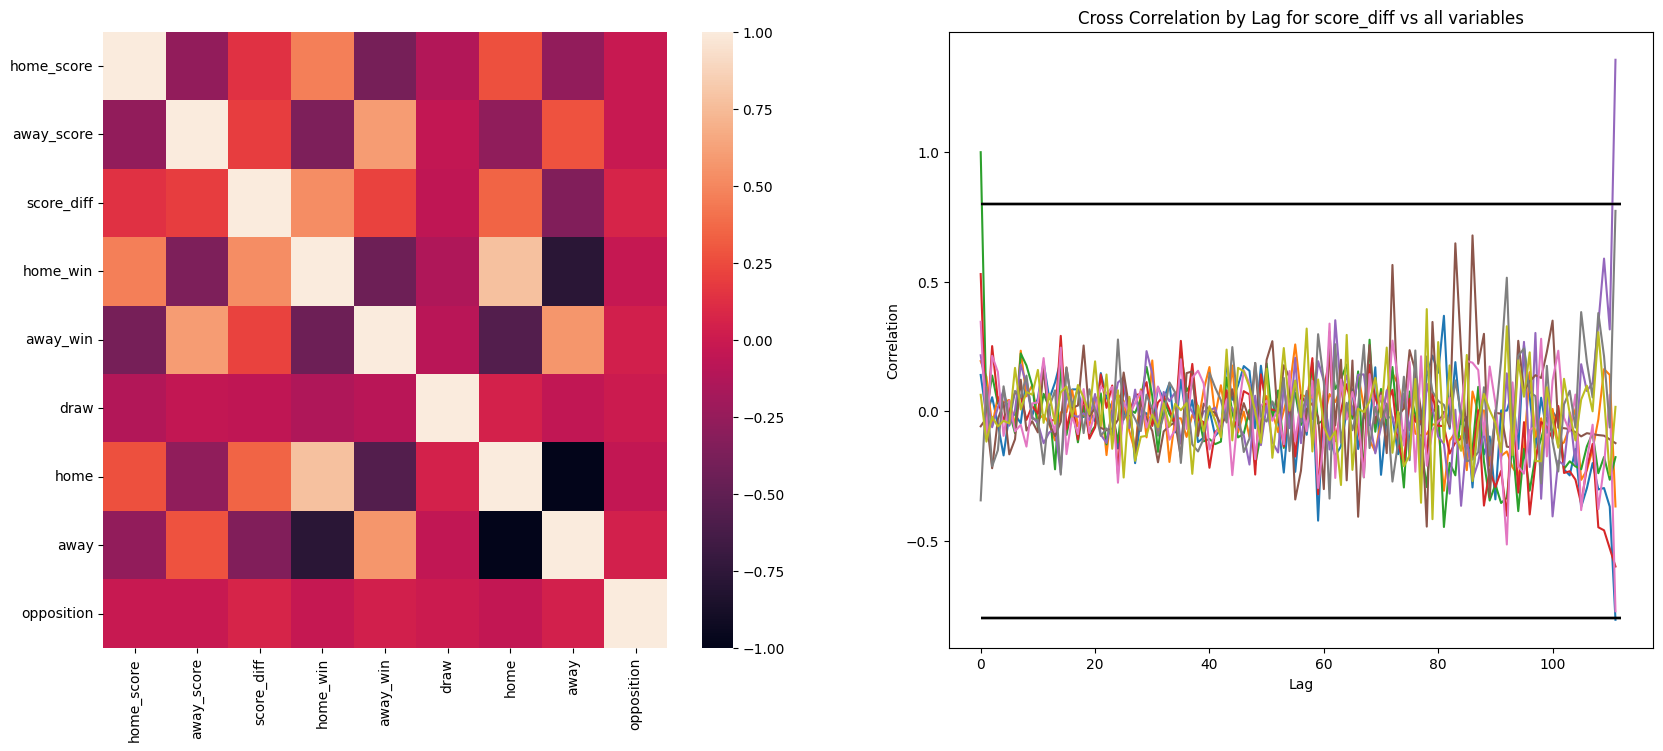

In [5]:
corr_df = team_df.copy()
corr_df = corr_df.drop(columns=['date', 'home_team', 'away_team'])
correlation_matrix = corr_df.corr()

fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))

sns.heatmap(correlation_matrix, ax = axes[0])

for var in corr_df.columns:
    ccf_val = ccf(corr_df['score_diff'], corr_df[var])
    ccf_df = pd.DataFrame({'Lag': [i for i in range(len(ccf_val))], "CCF": ccf_val})

    ccf_df = ccf_df[abs(ccf_df['CCF']) <= 1]
    axes[1].plot(ccf_val)
    axes[1].set_xlabel("Lag")
    axes[1].set_ylabel("Correlation")
    axes[1].set_title(f"Cross Correlation by Lag for score_diff vs all variables")
    axes[1].hlines(y = 0.8, xmin = 0, xmax = len(ccf_val), color = 'black')
    axes[1].hlines(y = -0.8, xmin = 0, xmax = len(ccf_val), color = 'black')

    sig_lag = ccf_df[abs(ccf_df['CCF']) >= 0.8]

    if len(sig_lag) > 0:
        print(var, sig_lag, sep = '\n')

plt.show()

### We create our lagged variables

In [6]:
## Create previous game encounter
previous_df = team_df.copy()
previous_df['date'] = pd.to_datetime(previous_df['date'])
previous_df['prev date'] = pd.to_datetime(previous_df.groupby('opposition')['date'].shift())
previous_df['diff'] = (previous_df['date'] - previous_df['prev date']).dt.days
previous_df['weight'] =  1/previous_df['diff'] ## This is to make the more recent results add more value to the model

previous_df['prev score_diff'] = previous_df.groupby('opposition')['score_diff'].shift()
previous_df['prev home_win'] = previous_df.groupby('opposition')['home_win'].shift()
previous_df['prev away_win'] = previous_df.groupby('opposition')['away_win'].shift()

previous_df['prev draw'] = previous_df.groupby('opposition')['draw'].shift()
previous_df['prev home'] = previous_df.groupby('opposition')['home'].shift()
previous_df['prev away'] = previous_df.groupby('opposition')['away'].shift()

previous_df = previous_df[['date', 'home_team', 'away_team', \
                           'prev score_diff', 'prev home_win', 'prev away_win', \
                           'prev draw', 'prev home', 'prev away', 'prev date', "weight"]]

## Merge the two df's 
team_df = pd.merge(left = team_df, right = previous_df, how = 'right', on = ['date', 'home_team', 'away_team'])
team_df['date'] = pd.to_datetime(team_df['date'])
team_df.dropna(inplace=True)
team_df = team_df[team_df['date'].dt.year >= lower_bound + 1].reset_index(drop = True)

### We move on to the Random Forest model

opposition:  England 
MSE =  75.624 
MAPE =  0.573 
R^2 =  0.365

opposition:  France 
MSE =  11.431 
MAPE =  0.591 
R^2 =  0.831

opposition:  Italy 
MSE =  276.243 
MAPE =  0.535 
R^2 =  -0.431

opposition:  Scotland 
MSE =  18.995 
MAPE =  0.698 
R^2 =  0.556

opposition:  Wales 
MSE =  62.684 
MAPE =  0.378 
R^2 =  0.575



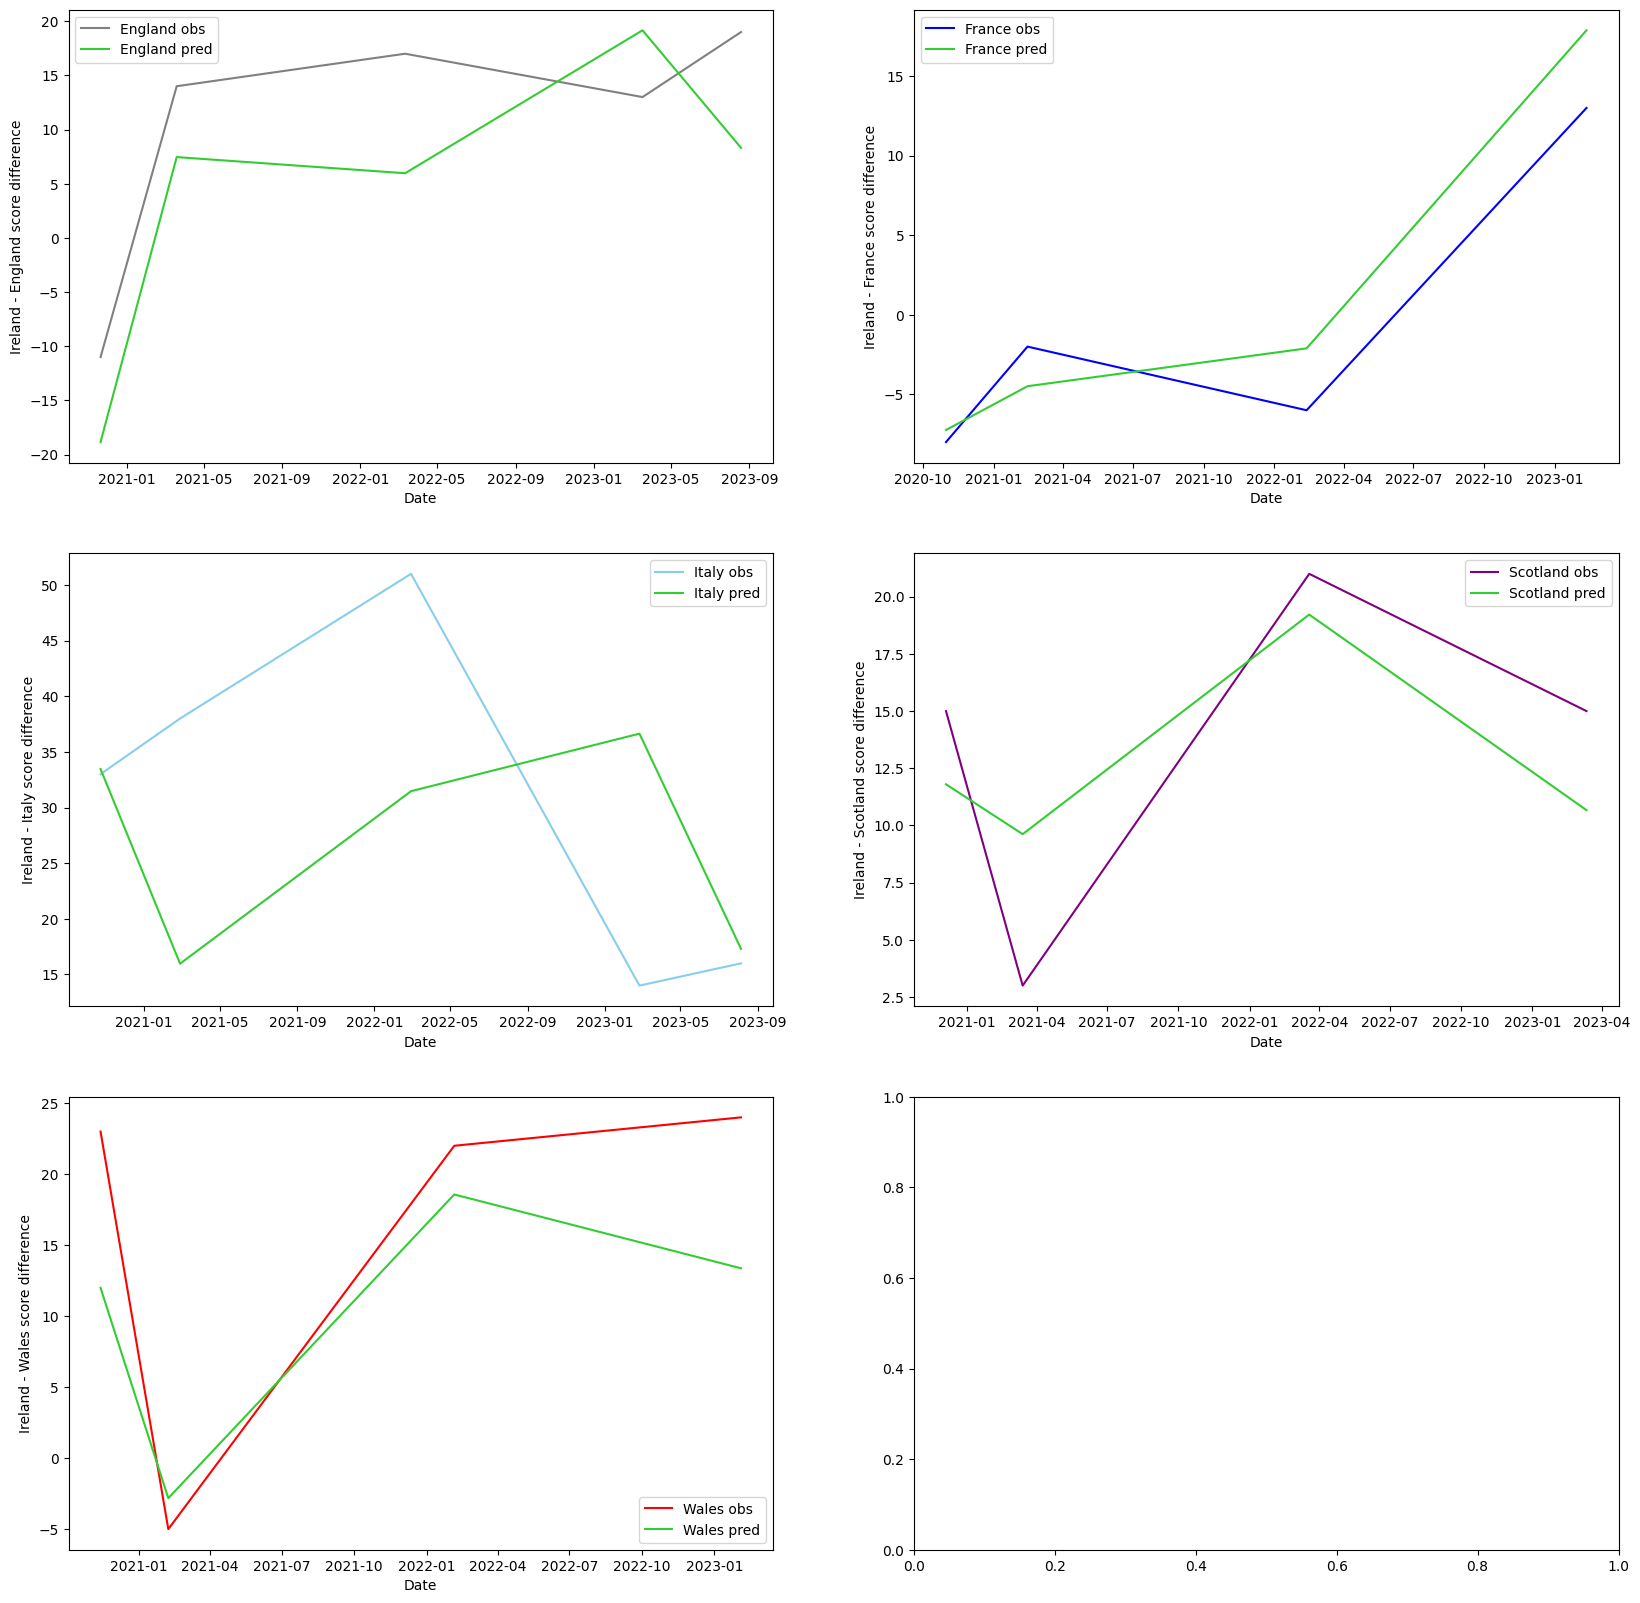

In [7]:
# Split X and Y
selected_params = ['home_win', 'away_win', 'draw', "home", 'away', 'opposition'
                   , 'prev score_diff', 'prev home_win', 'prev away_win'
                   , 'prev draw', 'prev home', 'prev away', "weight"]
model_df = team_df.copy()
model_df = model_df[(model_df['home_team'].isin(six_nations_teams)) & (model_df['away_team'].isin(six_nations_teams))].reset_index(drop = True)

matchup = model_df[['date', 'home_team', 'away_team']]
X = model_df[selected_params]
y = model_df['score_diff']

## Create training and testing
split_loc = int(0.7*len(model_df))
X_train, X_test = X[0:split_loc], X[split_loc:].reset_index(drop = True)
y_train, y_test = y[0:split_loc], y[split_loc:].reset_index(drop = True)
matchup_test = matchup[split_loc:].reset_index(drop = True)

## Create random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

## Create prediction dataframe with only Six Nations teams
prediction_df = pd.DataFrame({'Observed': y_test, "Predicted": pred})
prediction_df = pd.concat([matchup_test, prediction_df], axis = 1)
prediction_df['opposition'] = prediction_df.apply(lambda x: x['away_team'] if x['home_team'] ==  team else x['home_team'], axis = 1)
prediction_df = prediction_df[prediction_df['opposition'].isin(six_nations_teams)]

fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 20))

i = 0
for opposition, data in prediction_df.groupby('opposition'):
    subset = data.reset_index(drop = True)

    ## Metrics
    mse = mean_squared_error(subset['Observed'], subset['Predicted'])
    mape = mean_absolute_percentage_error(subset['Observed'], subset['Predicted'])
    r2 = r2_score(subset['Observed'], subset['Predicted'])
    print("opposition: ", opposition, "\nMSE = ", round(mse, 3), "\nMAPE = ", round(mape, 3), "\nR^2 = ", round(r2, 3), end = '\n\n')

    axs[i//2, i % 2].plot(subset['date'], subset['Observed'], label=str(opposition) + " obs", color = team_colours[opposition])
    axs[i//2, i % 2].plot(subset['date'], subset['Predicted'], label=str(opposition) + " pred", color = team_colours[team])
    axs[i//2, i % 2].set_xlabel("Date")
    axs[i//2, i % 2].set_ylabel(f"{team} - {opposition} score difference")
    axs[i//2, i % 2].legend()

    i += 1

plt.show()